# Neural Model - Learning Mechanism with Self Organizing Maps

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In this notebook we present a first implementation of a neural model for sound source elevation estimation based on the computational HRTF model. 

The learning should be done with a self-organizing map. However, this does not work (yet).



In [3]:
# Import necessary modules
from pathlib import Path
from src.data import generateData
from src.features import helpers as hp
from src.visualization import helpers as hpVis
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d,convolve1d
from scipy.signal import convolve2d
from IPython import display
from scipy.spatial import distance

ROOT = Path(os.getcwd()).resolve().parents[0]

SOUND_FILES = ROOT / 'data/raw/sound_samples/'
# create a list of the sound files
SOUND_FILES = list(SOUND_FILES.glob('**/*.wav'))


class LinearReg():

    def __init__(self, x, y):
        from sklearn.linear_model import LinearRegression

        self.lr_model = LinearRegression()

        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

        self.lr_model.fit(self.x, self.y)

        self.rr = self.lr_model.score(self.x, self.y)

    def get_fitted_line(self):
        return [self.x, self.lr_model.predict(self.x)]

    def get_coefficients(self):
        return self.lr_model.coef_[0, 0], self.lr_model.intercept_[0]

    def get_score(self, x=0, y=0):
        if x == 0 or y == 0:
            return self.rr
        else:
            return self.lr_model.score(x, y)

    def print_coefficients(self):
        print('Gain: {0:1.2f}, Bias: {1:1.2f}, , r^2: {2:1.2f}'.format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr))
        return ('Gain: {0:1.2f},\nBias: {1:1.2f},\n' + r'$r^2$: {2:1.2f}').format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr)





In [4]:
############################################################
#                  Simulation functions                    #
############################################################

tau = 0.05

# Defines the output transfer function of q_A_SC 
def out_thres(q,threshold = 0.0,slope=1):    
    return np.minimum(np.maximum((q-threshold)*slope,0),1)

   
# Defines the sigmoidal transfer function  
def out_sigmoid(x,slope =5,operation_point=0.0):
#     return 1 / (1 + np.exp(-(x-working_point)*slope) ) 
    tmp = (x-operation_point)*slope
    return (2 / (1 + np.exp(-4*tmp**2)))-1


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        tmp = np.exp(-(x-mean)**2 /( 2 * sigma**2 ))
        return tmp/np.max(tmp)
    
# define the ODE for inhibitory input neurons
def ode_p_in(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha=1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for gaussian filter neurons
def ode_r_in(r,excitatory_in,inhibitory_in):
    # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 200
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0.0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 200
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in  + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r / tau


# define the ODE for neuron p_sum
def ode_p_sum(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for integration neurons
def ode_r(r,excitatory_in,inhibitory_in=0):
    # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 2
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 1
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in   + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r /tau

# define the ODE for read out neurons
def ode_q_sum(q ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_q  = -alpha *q  + (beta -q )*excitatory_in
    
    return d_q /tau 


### Parameters

In [5]:
########################################################################
######################## Set parameters ################################
########################################################################
azimuth = 12
snr = 0.0
freq_bands = 128
participant_number = 1

normalize = False
time_window = 0.1  # time window in sec

# filtering parameters
normalization_type = 'sum_1'
sigma_smoothing = 0
sigma_gauss_norm = 1

# use the mean subtracted map as the learned map
mean_subtracted_map = True

ear = 'ipsi'

elevations = np.arange(0, 25, 1)


############################################################
#                  Simulation parameter                    #
############################################################

# Time step
dt = 0.001 # -> 

# Solve differential equation from time 0 to time T
T = 0.3# 
# Descretize time into equal steps
ts = np.linspace (0 , T , int ( T / dt )+1)


## SOM Learning

In [6]:

class SOM():
    
    def __init__(self,start_learning_rate,start_sigma,lambda_ = 100,grid_dim = (10,1), input_dim=2):
        np.random.seed(20)
        self.w = np.random.rand(grid_dim[0],grid_dim[1],input_dim)* 0.1 +0.5
        self.epsi_init = start_learning_rate
        self.epsi = self.epsi_init
        self.sigma_init = start_sigma
        self.sigma = self.sigma_init
        self.grid_dim = grid_dim
        self.t = 0
        self.lambda_ = lambda_
        self.ind_s = (0,0)
        self.grid = np.asarray(np.unravel_index(np.arange(grid_dim[0]*grid_dim[1]),grid_dim))
    
    def update_w(self,v):
        
        # determine best matching unit and its index
        tmp = np.sum((v-self.w)**2,2)**(1/2)
        s = tmp.min()
        # index on grid
        ind_s = np.asarray(np.unravel_index(np.argmin(tmp),self.grid_dim))
        self.ind_s  = ind_s   
        # create neigborhood function
        h = self.neighbour(self.grid,ind_s)
        # bring it back to grid stucture
        h = h.reshape(self.grid_dim[0],self.grid_dim[1])
        self.w += self.epsi * (h.T * (v-self.w).T).T
        
        # update the learning rate and neighborhood sigma
        self.update_rates()
        
        
    def neighbour(self,ind,ind_s):
        
        return np.exp( -  np.sum((ind.T-ind_s)**2,1) / (2*self.sigma**2) )
                      
    def update_rates(self):
        self.epsi = self.epsi_init * np.exp(-self.t / self.lambda_)
        self.sigma = self.sigma_init * np.exp(-self.t / self.lambda_)
        self.t += 1


In [7]:
#generate inputs
participant_number = 19

psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

elevations = np.arange(0, 25, 1)

# Use only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]

# Define neurons
# sounds_types = np.array([0,4,6,9,10])
sound_types = np.arange(0,10)
# sounds_types = np.array([0])

n_sounds = len(sound_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,5000,1)
n_elevations = len(elevations_angles)

sigma = 3

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)

net = SOM(0.001, 7, lambda_ = n_elevations*n_sounds ,grid_dim=(len(elevations),1),input_dim=freq_bands)


for i_sound,sound in enumerate(sound_types):
    for i_ele,ele in enumerate(elevations_angles):
        
        ele = np.random.randint(0,25)
        sound = np.random.choice(sound_types)
        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]

        
        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')
        excitatory_in_p_c = convolve1d(out_thres(in_c),weights=gauss_kernel,axis=0,mode='reflect')
        
        # visual guidance signal TODO
        v_in = np.zeros((len(elevations),1))
        v_in[ele] = 1 
        
        p_in_c = np.zeros((len(ts),freq_bands))
        p_in_i = np.zeros((len(ts),freq_bands))

        r_in_c = np.zeros((len(ts),freq_bands))
        r_in_i = np.zeros((len(ts),freq_bands))

        p_sum_i = np.zeros((len(ts),freq_bands))
        p_sum_c = np.zeros((len(ts),freq_bands))
        
        r_ipsi = np.zeros((len(ts),freq_bands))
        q = np.zeros((len(ts),len(elevations)))
        
        w = np.squeeze(net.w)
        
        for t in range(0,len(ts)-1):
            
            
            ## p_In_ipsi neuron
            # feed inputs ipsi inhibition
            p_in_i[t+1,:] = p_in_i[ t,:] + dt* ode_p_in(p_in_i[t,:],excitatory_in_p_i)  

            ## r_In_ipsi neuron
            excitatory_in = out_thres(in_i)
            inhibitory_in = out_thres(p_in_i[ t,:])
            r_in_i[ t+1,:] = r_in_i[t,:] + dt* ode_r_in(r_in_i[t,:],excitatory_in,inhibitory_in)   

            ## p_In_contra neuron
            # feed inputs ipsi inhibition
            p_in_c[ t+1,:] = p_in_c[ t,:] + dt* ode_p_in(p_in_c[t,:],excitatory_in_p_c)  

            ## r_In_contra neuron
            excitatory_in = out_thres(in_c)
            inhibitory_in = out_thres(p_in_c[ t,:])
            r_in_c[t+1,:] = r_in_c[t,:] + dt* ode_r_in(r_in_c[t,:],excitatory_in,inhibitory_in)   

            
            ## p_sum neurons
            excitatory_in = out_thres(r_in_i[ t,:]) 
            p_sum_i[ t+1,:] = p_sum_i[ t,:] + dt* ode_p_sum( p_sum_i[ t,:],excitatory_in)   
            
            excitatory_in = out_thres(r_in_c[ t,:]) 
            p_sum_c[ t+1,:] = p_sum_c[ t,:] + dt* ode_p_sum(p_sum_c[ t,:],excitatory_in)   
            
            
            ## r_ipsi neuron
            excitatory_in = out_thres(r_in_i[t,:])
            inhibitory_in = out_thres(p_sum_i[ t,:]) + out_thres(p_sum_c[ t,:])
            r_ipsi[ t+1,:] = r_ipsi[ t,:] + dt* ode_r(r_ipsi[t,:],excitatory_in,inhibitory_in)   
            
            ## q readout neurons
            excitatory_in = np.sum(r_ipsi[ t,:] * w[:,:],axis=1)
            q[ t+1,:] = q[ t,:]+ dt* ode_q_sum(q[t,:],excitatory_in)   
            
            

            
            # neighborhood function
#             if t > 1000:
            if t == 299:    
                s = np.squeeze(q[ t,:])
                v = np.squeeze(r_ipsi[ t,:])
                
                
                net.update_w(v)
                w = np.squeeze(net.w)

                
                if i_ele % 50 == 0:
            
                
                    display.clear_output(wait=True)
                    #fig = plt.figure(figsize=(5,5))
                    #ax = fig.add_subplot(1,2,1)
                    #a = ax.pcolorfast(w)
                    #plt.colorbar(a)

                    #plt.tight_layout()
                    #plt.show()
                    print(i_sound,i_ele)
                
                

            
            
            
#             if t%500 == 0:
#                 clear_output(wait=True)
#                 print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations)+'.\n  -> Time : '+str(t))        

9 4950


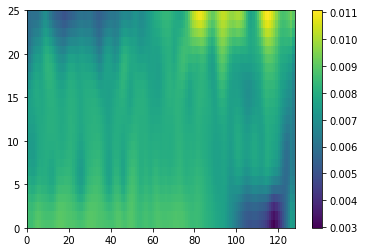

In [8]:


tmp = np.squeeze(net.w)

tmp = (tmp.T/ tmp.sum(1)).T

#tmp[-3:,:] = 0
plt.pcolormesh(tmp)

plt.colorbar()

w_ = tmp

<IPython.core.display.Javascript object>

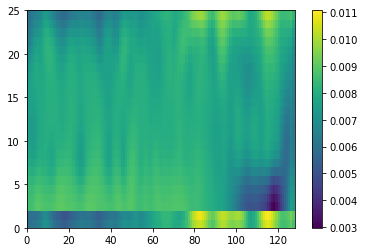

In [9]:
%notify
w_tmp = np.copy(np.squeeze(net.w))

w_tmp = np.roll(w_tmp,2,axis=0)

w_tmp = (w_tmp.T/ w_tmp.sum(1)).T


plt.pcolormesh(w_tmp)
plt.colorbar()



In [10]:
#generate inputs
psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

# Take only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]

# Define neurons
# sounds_types = np.array([0,4,6,9,10])
sounds_types = np.arange(0,20)
# sounds_types = np.array([0])

n_sounds = len(sounds_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,25,1)
n_elevations = len(elevations_angles)

sigma = 3

q = np.zeros((n_sounds,n_elevations,len(ts),len(elevations)))

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)

results = np.zeros((len(sounds_types),len(elevations_angles),3))

for i_sound,sound in enumerate(sounds_types):
    for i_ele,ele in enumerate(elevations_angles):

        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]

        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')
        excitatory_in_p_c = convolve1d(out_thres(in_c),weights=gauss_kernel,axis=0,mode='reflect')
        
        p_in_c = np.zeros((len(ts),freq_bands))
        p_in_i = np.zeros((len(ts),freq_bands))

        r_in_c = np.zeros((len(ts),freq_bands))
        r_in_i = np.zeros((len(ts),freq_bands))

        p_sum_i = np.zeros((len(ts),freq_bands))
        p_sum_c = np.zeros((len(ts),freq_bands))
        r_ipsi = np.zeros((len(ts),freq_bands))
        q_ele = np.zeros((len(ts),len(elevations)))
                

        for t in range(0,len(ts)-1):
            
            
                        ## p_In_ipsi neuron
            # feed inputs ipsi inhibition
            p_in_i[ t+1,:] = p_in_i[ t,:] + dt* ode_p_in(p_in_i[t,:],excitatory_in_p_i)  

            ## r_In_ipsi neuron
            excitatory_in = out_thres(in_i)
            inhibitory_in = out_thres(p_in_i[ t,:])
            r_in_i[ t+1,:] = r_in_i[ t,:] + dt* ode_r_in(r_in_i[t,:],excitatory_in,inhibitory_in)   

            ## p_In_contra neuron
            # feed inputs ipsi inhibition
            p_in_c[ t+1,:] = p_in_c[ t,:] + dt* ode_p_in(p_in_c[t,:],excitatory_in_p_c)  

            ## r_In_contra neuron
            excitatory_in = out_thres(in_c)
            inhibitory_in = out_thres(p_in_c[ t,:])
            r_in_c[ t+1,:] = r_in_c[ t,:] + dt* ode_r_in(r_in_c[t,:],excitatory_in,inhibitory_in)   

            
            ## p_sum neurons
            excitatory_in = out_thres(r_in_i[ t,:]) 
            p_sum_i[ t+1,:] = p_sum_i[ t,:] + dt* ode_p_sum( p_sum_i[ t,:],excitatory_in)   
            
            excitatory_in = out_thres(r_in_c[ t,:]) 
            p_sum_c[ t+1,:] = p_sum_c[ t,:] + dt* ode_p_sum(p_sum_c[ t,:],excitatory_in)   
            
            
            ## r_ipsi neuron
            excitatory_in = out_thres(r_in_i[ t,:])
            inhibitory_in = out_thres(p_sum_i[ t,:]) + out_thres(p_sum_c[ t,:])
            r_ipsi[ t+1,:] = r_ipsi[ t,:] + dt* ode_r(r_ipsi[t,:],excitatory_in,inhibitory_in)   
            
             ## q readout neurons
            excitatory_in = np.sum(r_ipsi[ t,:] * w_,axis=1)
            q_ele[ t+1,:] = q_ele[ t,:]+ dt* ode_q_sum(q_ele[t,:],excitatory_in) 

            if t%500 == 0:
                clear_output(wait=True)
                print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations)+'.\n  -> Time : '+str(t))        
                
        dists = distance.cdist(w_, (r_ipsi[ t,:,np.newaxis]).T, metric='correlation')
        minimal_dist_ind = np.argmin(dists)
#         print('Real elevation: '+str(ele))
#         print('Correlation: '+str(minimal_dist_ind)+'  Neuron: '+ str(q[ -10,:].argmax()))
#         print()
        
        ## save results
        # real location
        results[i_sound,i_ele,0] = ele
        # correlation
        results[i_sound,i_ele,1] = minimal_dist_ind
        # neuron activation
        results[i_sound,i_ele,2] = q_ele[ -10,:].argmax()
             
#             if t%2950 == 0:

#                 print('Neuron: '+ str(excitatory_in.argmax()))
            
           

Sound No: 20 of 20.
  -> Elevation : 25 of 25.
  -> Time : 0


<IPython.core.display.Javascript object>

Correlation:
Gain: 0.02, Bias: 10.13, , r^2: 0.00
Neuron:
Gain: 0.03, Bias: 5.93, , r^2: 0.00


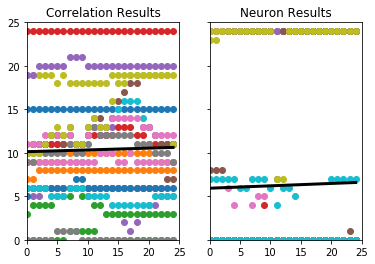

In [11]:
%notify
fig = plt.figure()

axes = fig.subplots(1,2,squeeze=False,sharex=True,sharey=True)

ax1 = axes[0,0]
ax1.set_title('Correlation Results')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(results[i_sound,:,0],results[i_sound,:,1])

lr = LinearReg(np.squeeze(results[:,:,0]),np.squeeze(results[:,:,1]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Correlation:')
lr.print_coefficients()
ax1.set_ylim([0,25])
ax1.set_xlim([0,25])

ax1 = axes[0,1]
ax1.set_title('Neuron Results')
for i_sound,sound in enumerate(sounds_types):
    ax1.scatter(results[i_sound,:,0],results[i_sound,:,2])
    
lr = LinearReg(np.squeeze(results[:,:,0]),np.squeeze(results[:,:,2]))
x,y = lr.get_fitted_line()
ax1.plot(x,y,linewidth = 3,color='black')
print('Neuron:')
lr.print_coefficients()
# ax1.set_ylim([0,25])
# ax1.set_xlim([0,25])
plt.show()